# Basic classification using the VGP model

This notebook explains how to use Markovflow to build and optimise a variational GP regression model (VGP) for a time series. Here, we perform binary classification with time as the input.

As with GPR, the observations do not have to be regularly spaced. However, they do need to be sequential. We denote the input/output tuples as $(x_i, y_i)_{1 \leq i \leq n}$, where $x_i$ is a scalar value and $y_i \in \{0, 1\}$.

Our probabilistic model for this data is:
$$
\begin{align}
f \sim \mathcal{GP}(0, k(., .)) \\
y_i \sim \mathcal{B}(\Phi(f(x_i)))
\end{align}
$$

where $\Phi$ is a function that maps $f(x_i)$ to $[0, 1]$, the probability that $y_i=1$. In practice, we choose $\Phi$ to be the standard normal cumulative distribution function (also known as the probit function) which maps to $[0, 1]$.

**NOTE:** If you have difficulty running this notebook, consider clearing the output and then restarting the kernel.

In [1]:
# Setup

import warnings

# Turn off warnings
warnings.simplefilter('ignore')

from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow

from gpflow import default_float, set_trainable
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Bernoulli

from markovflow.models.variational import VariationalGaussianProcess
from markovflow.kernels import Matern12, Product, HarmonicOscillator


FLOAT_TYPE = default_float()

# uncomment in notebook
# try:
#     from IPython import get_ipython
#     get_ipython().run_line_magic('matplotlib', 'inline')
# except AttributeError:
#     print('Magic function can only be used in IPython environment')
#     matplotlib.use('Agg')

plt.rcParams["figure.figsize"] = [15, 8]

2022-09-17 15:49:43.962455: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:49:43.962494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 1: Generate training data

First, let's generate some binary data $X = (x_1, \dots, x_n)$ and $Y = (y_1, \dots, y_n)^T$.

Text(0, 0.5, 'Label')

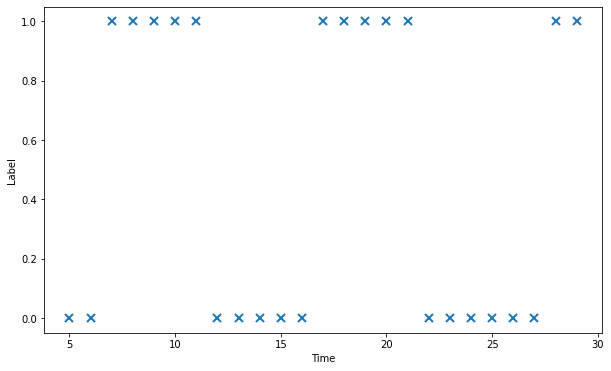

In [2]:
def create_binary_observations(time_points: np.ndarray) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    A helper function to create training data.
    :param time_points: Time points to generate observations for.
    :return: Tuple[x,y] Data that represents the observations' shapes:
        X = [num_points, 1],
        Y = [num_points, state_dim , 1] where state_dim is currently 1
    """
    period = 12.
    observations = np.sin(12 * time_points[..., None])
    # Add some noise
    observations += np.random.randn(len(time_points), 1) * .3

    logic = (observations > 0)
    binary = (logic.astype(int) * 1)

    return time_points, binary

# Generate some observations
time_points, observations = create_binary_observations(np.arange(5.0, 30.0))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_points, observations, 'C0x', ms=8, mew=2)
plt.xlabel("Time")
plt.ylabel("Label")

## Step 2: Choose a kernel

To build a model we need a Markovian kernel, that is, one that has an equivalent Stochastic Differential Equation (SDE) representation. The SDE framework covers a large variety of well-known kernels and precisions. 

You can combine these kernels by taking their sums or products. 

In this case, we notice that the data looks roughly periodic, so we combine the Matern12 and periodic kernels using the product kernel.

**NOTE:** Avoid any Sum combinations that use periodic kernels, because these will fail (for example, `Sum(periodic,any other kernel)`.

**NOTE:** Choosing a higher-order Matern kernel for VGPs using the Markovflow SDE representation could result in over-parameterisation (resulting in Cholesky errors).

In [3]:
period = 10.0
periodic_kernel = HarmonicOscillator(variance=2.0, period=period)
matern_kernel = Matern12(lengthscale=6. * period, variance=1.0)
# Because we are multiplying them together, we need to train only one kernel variance parameter
set_trainable(matern_kernel.variance, False)

kernel = Product([matern_kernel, periodic_kernel])

# We see Matern12 has only two dimensions (therefore there is less risk of overparameterising)
print(kernel.state_dim)

2


2022-09-17 15:49:45.583757: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 15:49:45.583965: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:49:45.583976: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 15:49:45.583994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-774): /proc/driver/nvidia/version does not exist
2022-09-17 15:49:45.584241: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F F

## Step 3: Build and optimise a model

This is a classification problem with outputs between `[0,1]`, so we create a variational GP model using a Bernoulli likelihood.

In [4]:
# Create a likelihood object
bernoulli_likelihood = Bernoulli()

input_data = (tf.constant(time_points), tf.constant(observations))
vgpc = VariationalGaussianProcess(input_data=input_data, kernel=kernel,
                                  likelihood=bernoulli_likelihood)

Instructions for updating:
Do not call `graph_parents`.


(**NOTE:** The following comments are true for training VGPs in general, and are not unique to Markovflow.)

Recall that when applying the GPR model in the regression context, we sought to maximise the marginal likelihood with respect to the hyperparameters (that is, the kernel parameters and the likelihood variance).

Unlike traditional GPR, the posterior on 𝑓 given the data is not Gaussian anymore, and there is no closed form expression for it. Instead, we use variational inference to find the Gaussian distribution that gives the best approximation to the true posterior in terms of the Kullback-Leibler (KL) divergence. KL divergence quantifies how different two probability distributions are. 

To do this, maximise the Evidence Lower Bound (ELBO) using a form of gradient-based optimisation such as gradient descent or Adam. Maximising the ELBO is equivalent to minimising the KL divergence. The intention is to make our posterior approximation as close as possible to the true posterior.  

As such, there are two training phases required for VGPR: 
firstly, we adjust the (Gaussian) parameters for our posterior approximation, and secondly, we adjust the hyperparameters (as in traditional GPR).

The theoretically correct, precise way to conduct both steps would be to optimise phase 1 until convergence, then perform a small optimisation step for phase 2 and repeat. However, jointly optimising the variational parameters and the hyperparameters works well in practice and is faster. 

In practice, we take single steps for phase 1 and 2, and then repeat. Often this approach works well enough and converges much faster than the precise approach mentioned previously. 

### Markflow implementation notes 
* Markovflow combines both training phases, so it appears in the following example as a single optimisation step.
* Markovflow models often share common interfaces, including a loss method to train on, so here we are minimising a loss value (which is equivalent to maximising ELBO).
* If you encounter 'Banded Cholesky decomposition failure' errors during training, it _could_ be indicative of poor input scaling, hyperparameter misspecification, or overly aggressive optimisation (that is, the learning rate is too large). 

In [5]:
# equivalent to loss = -vgpc.elbo()
loss = vgpc.loss()

# Before optimisation, calculate the loss of the observations given the current kernel parameters
print("Loss before optimisation: ", loss.numpy())

Loss before optimisation:  31.18199464278479


In [6]:
# Start at a small learning rate 
learning_rate = 0.001
max_iter = ci_niter(2000)

opt = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def opt_step():
    opt.minimize(vgpc.loss, vgpc.trainable_variables)

for i in range(max_iter):
    opt_step()
    if i % 500 == 0:
        print(f"Iteration: {i}\tLoss: {vgpc.loss()}")

print(f"Loss after optimisation: {vgpc.loss()}")

# Save our trained hyperparamters (these will be used in Step 8)
saved_hyperparams = kernel.trainable_variables

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


2022-09-17 15:49:52.622775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-17 15:49:52.673075: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


Iteration: 0	Loss: 30.64525364181372


Iteration: 500	Loss: 11.041065961553501


Iteration: 1000	Loss: 9.239665802444875


Iteration: 1500	Loss: 8.339189503986535


Loss after optimisation: 7.768689351743879


We can see how our kernel parameters have changed from our initial values. 

In [7]:
gpflow.utilities.print_summary(vgpc._kernel)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ Product._kernels[0]._state_mean  │ Parameter │ Identity    │         │ False       │ (1,)    │ float64 │ [0.]               │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ Product._kernels[0]._lengthscale │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 59.410814670763195 │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ Product._kernels[0]._variance    │ Parameter │ Softplus    │         │ False       │ ()      │ float64

## Step 4: Generate a (posterior) mean for the training data
As with GPR, we can get the posterior means of the true function values without observation noise. This is less applicable in a classification scenario, but could be useful in other VGPR applications.

We use `vgpc.posterior.predict_y` to get the posterior of the latent function at the future times that we want to predict.

We then pass these latent predictions through our function $\Phi$ (this effectively squashes our latent function values to between $[0,1]$).

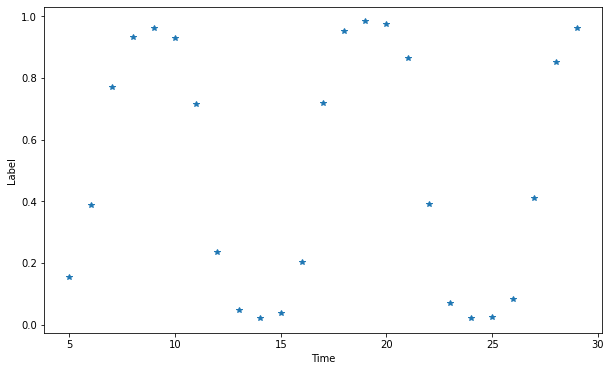

In [8]:
# Obtain means and covariances for latent predictions
pred = vgpc.posterior

latent_mean, latent_var = pred.predict_y(tf.constant(time_points))

# Define our function $\Phi$
from scipy.special import erf


def Phi(x):  # NumPy version of the inv_probit
    jitter = 1e-3  # Ensures that the output is strictly between 0 and 1
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


# Plot the results
mean = Phi(latent_mean)

plt.figure(figsize=(10, 6))
plt.plot(time_points, latent_mean, 'C0*')
plt.xlabel("Time")
plt.ylabel("Label")
plt.show()

## Step 5: Make a prediction for the future
We use `vgpc.posterior.predict_f` to get the posterior of the latent function at the future times that we want to predict.

Then, similar to Step 4, we pass these latent predictions through our function $\Phi$.

Let's start by predicting what class we forecast to occur at `t=33`.

In [9]:
# Create a new observation for us to evaluate the prediction
new_time_to_predict, actual_val_for_new_time = create_binary_observations(np.array([33.]))

# Obtain latent predictions from our GP
latent_predicted_mean_future_single, latent_predicted_cov_future_single = \
    pred.predict_f(tf.constant(new_time_to_predict, dtype=FLOAT_TYPE))

# Map these latent predictions through the inverse link function Φ
predicted_mean_future_single = Phi(latent_predicted_mean_future_single)

print("\nPredicted value", predicted_mean_future_single, "  Actual value", actual_val_for_new_time)


Predicted value [[0.18021729]]   Actual value [[0]]


Now let's forecast the mean trajectory over time. **NOTE:** As we move further away from known values, our uncertainly increases, and our forecasted mean values revert back to the prior (that is, zero mean). 

When you plot the data, the black cross corresponds to the forecasted value, and the red star corresponds to the true value. 

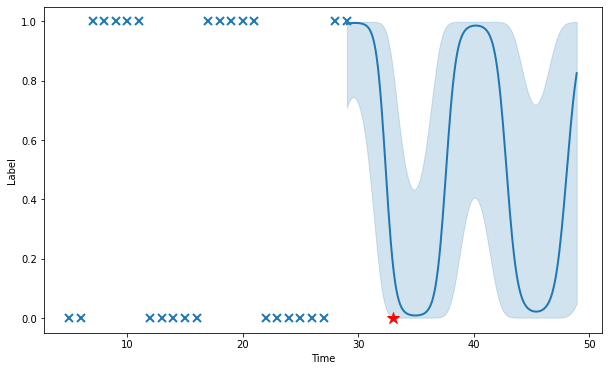

In [10]:
# Generate some time points in the future
future_time_points = np.arange(time_points[-1] + 0.01, time_points[-1] + 20.0, 0.1)

# Obtain latent predictions from our GP
latent_predicted_mean_future, latent_predicted_cov_future = \
    pred.predict_f(tf.constant(future_time_points, dtype=FLOAT_TYPE))

# Map these latent predictions through the inverse link function Φ
predicted_mean_future = Phi(latent_predicted_mean_future)

# Plot the means and covariances for these future time points
plt.figure(figsize=(10, 6))
plt.plot(future_time_points, predicted_mean_future, 'C0', lw=2)
plt.fill_between(future_time_points,
                 Phi(latent_predicted_mean_future[:, 0] - 2 * np.sqrt(
                     latent_predicted_cov_future[:, 0])),
                 Phi(latent_predicted_mean_future[:, 0] + 2 * np.sqrt(
                     latent_predicted_cov_future[:, 0])),
                 color='C0', alpha=0.2)

plt.plot(new_time_to_predict, actual_val_for_new_time, 'r*', markersize=12)
plt.plot(new_time_to_predict, predicted_mean_future_single, 'k', markersize=12)
plt.plot(time_points, observations, 'C0x', ms=8, mew=2)
plt.xlabel("Time")
plt.ylabel("Label")
plt.show()

## Step 6: Show a history of confidence

We can use the same trained VGP and fill in the unknown or unobserved points from the past to estimate how likely it is that we would have observed one class or another. 

This is achieved by the `vgpc.posterior.predict_f` method.

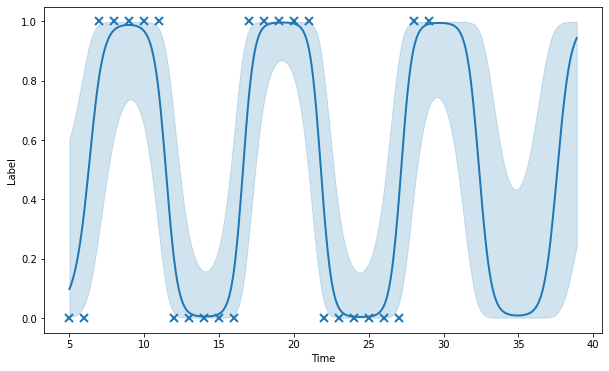

In [11]:
# Generate some other time points to evaluate
intermediate_time_points = np.arange(time_points[0], time_points[-1] + 10.0, 0.1)

# Obtain estimates at these points
latent_predicted_mean, latent_predicted_cov = \
    pred.predict_f(tf.constant(intermediate_time_points, dtype=FLOAT_TYPE))
latent_predicted_mean, latent_predicted_cov = (latent_predicted_mean.numpy(),
                                               latent_predicted_cov.numpy())

predicted_mean = Phi(latent_predicted_mean)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(intermediate_time_points, predicted_mean, 'C0', lw=2)
plt.plot(time_points, observations, 'C0x', ms=8, mew=2)
plt.fill_between(intermediate_time_points,
                 Phi(latent_predicted_mean.squeeze() - 2 * np.sqrt(latent_predicted_cov.squeeze())),
                 Phi(latent_predicted_mean.squeeze() + 2 * np.sqrt(latent_predicted_cov.squeeze())),
                 color='C0', alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Label")
plt.show()

## Step 7: Generate sample trajectories
You can also use the `vgpr.posterior.sample_f`method to generate sample trajectories.

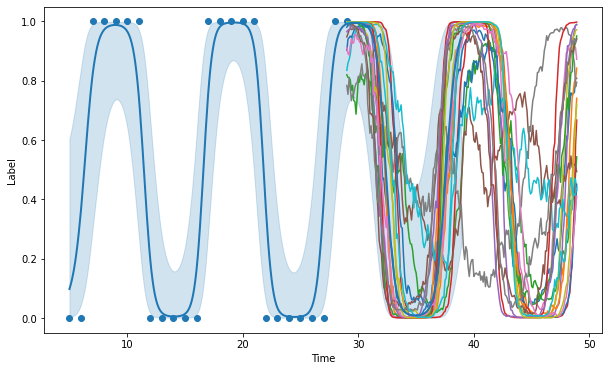

In [12]:
# Take 20 samples
latent_samples = \
    pred.sample_f(tf.constant(future_time_points, dtype=FLOAT_TYPE), 20)
latent_samples = latent_samples.numpy()

samples = Phi(latent_samples)

# Plot the same as previous
plt.figure(figsize=(10, 6))
plt.plot(time_points, observations, 'C0o')

# Add the samples
plt.plot(future_time_points[..., None], np.swapaxes(samples, 0, 1).squeeze())

# Add mean and confidence levels
plt.plot(intermediate_time_points, predicted_mean, 'C0', lw=2)
plt.fill_between(intermediate_time_points,
                 Phi(latent_predicted_mean.squeeze() - 2 * np.sqrt(latent_predicted_cov.squeeze())),
                 Phi(latent_predicted_mean.squeeze() + 2 * np.sqrt(latent_predicted_cov.squeeze())),
                 color='C0', alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Label")
plt.show()

## Step 8: Observe more data in the future, and update the model

You can also use `vgpc.posterior.predict_f` to get the posterior of the latent function at arbitrary time points.
To demonstrate this, we will generate a set of time points that begin before the training data and extend into the future.  

In the GPR notebook example, we could make reasonable predictions **without retraining** after observing a new point. We could do this because we could assume that the kernel trained on the 20 original points is probably still applicable for 21 points. In simple terms, you can think of learned kernel hyperparamters as general, high-level properties of the data (not unlike how an average value provides a high-level indication of a dataset). By reusing the hyperparamters, we are assuming that these high-level properties haven't changed. Similarly for VGPR, it is probably reasonable to assume the kernel parameters won't have changed materially after one extra observation, so it is not critical to retrain these. 

Recall, however, that VGPR had a two-step training process (hyperparameters and latent approximation). Unfortunately, the latent approximations of the posterior can be very specific to the dataset they were trained on. Because of this, adding a new observation requires retraining of this approximation. 

The following code describes how kernel hyperparameters are reused but retraining is performed on the latent approximation (phase 1, as described in Step 3).

Iteration: 0	Loss: 35.90683177528676


Iteration: 500	Loss: 12.421626540003315


Iteration: 1000	Loss: 10.447366023173851


Iteration: 1500	Loss: 9.514287561605869


Loss after optimisation: 8.964551854956564


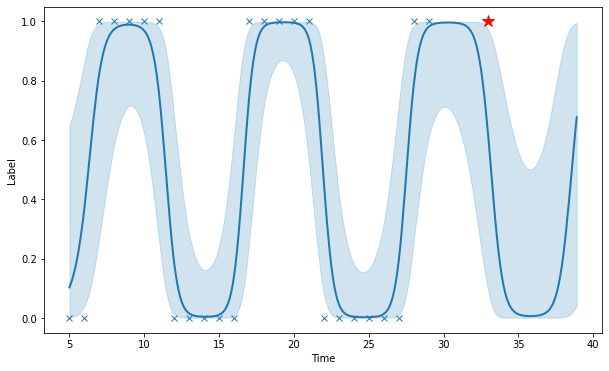

In [13]:
# Create a new observation and add it to the dataset
new_time, new_ob = create_binary_observations(np.array([33.]))
new_time_points = np.concatenate([time_points, new_time], axis=0)
new_observations = np.concatenate([observations, new_ob], axis=0)

# Create a new VGP object with the previous kernel
input_data = (tf.constant(new_time_points), tf.constant(new_observations))
vgpc = VariationalGaussianProcess(input_data=input_data, kernel=kernel, likelihood=Bernoulli())

opt = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def opt_step():
    opt.minimize(vgpc.loss, vgpc.trainable_variables)

for i in range(max_iter):
    opt_step()
    if i % 500 == 0:
        print(f"Iteration: {i}\tLoss: {vgpc.loss()}")

print(f"Loss after optimisation: {vgpc.loss()}")

# Obtain latent predictions 
pred = vgpc.posterior
latent_predicted_mean, latent_predicted_cov = \
    pred.predict_f(tf.constant(intermediate_time_points, dtype=FLOAT_TYPE))
latent_predicted_mean, latent_predicted_cov = (latent_predicted_mean.numpy(),
                                               latent_predicted_cov.numpy())

predicted_mean = Phi(latent_predicted_mean)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(intermediate_time_points, predicted_mean, 'C0', lw=2)
plt.plot(time_points, observations, 'C0x')
plt.fill_between(intermediate_time_points,
                 Phi(latent_predicted_mean[:, 0] - 2 * np.sqrt(latent_predicted_cov[:, 0])),
                 Phi(latent_predicted_mean[:, 0] + 2 * np.sqrt(latent_predicted_cov[:, 0])),
                 color='C0', alpha=0.2)
plt.plot(new_time, new_ob, 'r*', markersize=12)
plt.xlabel("Time")
plt.ylabel("Label")

plt.show()

When new data is available we can we see how the variance (slightly) decreases at the new point (shown by the red star).